# Vegas Notebook for WIC MC Generation

In [1]:
import numpy as np
from numpy import genfromtxt
from numpy import random
import matplotlib as mpl
import matplotlib.gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy as sp
from scipy.integrate import quad, dblquad, tplquad, simpson
from scipy import interpolate
from parton import mkPDF
import vegas
import pandas as pd
from functools import partial 

## My imports
import WIC_Pheno_Formulae as WIC
from WIC_Pheno_Formulae import *
import PlottingModules as PM
import VegasMC_Generation as VMC
from VegasMC_Generation import *
import ConvertToLHE

## Import Spectral Densities  (w/ correct normalization!)

Text(0, 0.5, '$\\rho$(μ) ($GeV^{-2}$)')

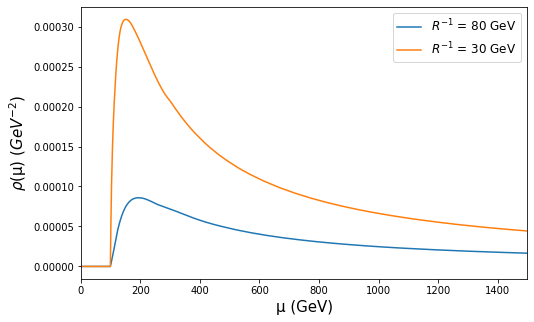

In [2]:
μs = np.linspace(0,15000,15001)

## With k = 10^10 GeV  ( k = 10^17 pushes the model into the invisible cascade regime )
ϼ100R30_k1010CSV = genfromtxt('SpectralDensityCSVs/SD100R30_k1010.csv', delimiter=',')
ϼ100R80_k1010CSV = genfromtxt('SpectralDensityCSVs/SD100R80_k1010.csv', delimiter=',')
μs1, ϼ100R30_k1010 = ϼ100R30_k1010CSV[:,0], ϼ100R30_k1010CSV[:,1]
μs2, ϼ100R80_k1010 = ϼ100R80_k1010CSV[:,0], ϼ100R80_k1010CSV[:,1]

## Multiply by μ
μϼ100R30_k1010 = ϼ100R30_k1010*μs1
μϼ100R80_k1010 = ϼ100R80_k1010*μs2

## Interpolate
ϼ100R30_k1010 = interpolate.interp1d(μs1, ϼ100R30_k1010)
ϼ100R80_k1010 = interpolate.interp1d(μs2, ϼ100R80_k1010)
μϼ100R30_k1010 = interpolate.interp1d(μs1, μϼ100R30_k1010)
μϼ100R80_k1010 = interpolate.interp1d(μs2, μϼ100R80_k1010)


fig, ax = plt.subplots(1, 1, figsize = (8,5));
μs = np.linspace(0,15000,15001)
μsNEW = np.linspace(1,2499,2500)
ax.plot(μsNEW, ϼ100R80_k1010(μsNEW))
ax.plot(μsNEW, ϼ100R30_k1010(μsNEW))
ax.legend([r'$R^{-1}$ = 80 GeV','$R^{-1}$ = 30 GeV'], fontsize=12)
ax.set_xlim(0,1500)
ax.set_xlabel('μ (GeV)', size=15)
ax.set_ylabel(r'$\rho$(μ) ($GeV^{-2}$)', size=15)
# plt.savefig('Paper/Plots/SpectralDensity_k1010_R30.png')

# Cross Section σ

In [3]:
## Training & Unweighting for Production Cross Section  # 500,000 takes ~ 30 min
dσ_dμdμp_sqrtS_500_dict = VMC.run_MC_dσ_dμdμp(NPoints=250000, sqrtS=500, μ0=100, μϼ=μϼ100R80_k1010) 
dσ_dcosθ_dict = VMC.run_MC_dσ_dcosθ(NPoints=100000)

Running dσ/dμdμp MC for √s = 500 ... 
(242001,) (242001,)
0 of 31152
5000 of 31152
10000 of 31152
15000 of 31152
20000 of 31152
25000 of 31152
30000 of 31152
shape of raw hist = (242001,)
shape of rescaled hist = (10917,)
Unweighting Efficiency = 0.04511138383725687
Returning μ1, μ1p Events, Integral
Running dσ/dcosθ MC ... 
(93086,)
0 of 12000
5000 of 12000
10000 of 12000
(93086,)
(15984,)
Returning cosθ Events, Integral


In [4]:
# Number of Events & Integrals
print("# of (μ,μ') events: " + str(np.shape(dσ_dμdμp_sqrtS_500_dict["μ1 Events"])))
print("# of  cosθ  events: " + str(np.shape(dσ_dcosθ_dict["cosθ Events"])))
## Total Cross Section
print('Total Cross Section: ')
print('σ = ' + str(dσ_dμdμp_sqrtS_500_dict['Integral']*dσ_dcosθ_dict["Integral"]) + ' ab ')

# of (μ,μ') events: (10917,)
# of  cosθ  events: (15984,)
Total Cross Section: 
σ = 67.49716879855883 ab 


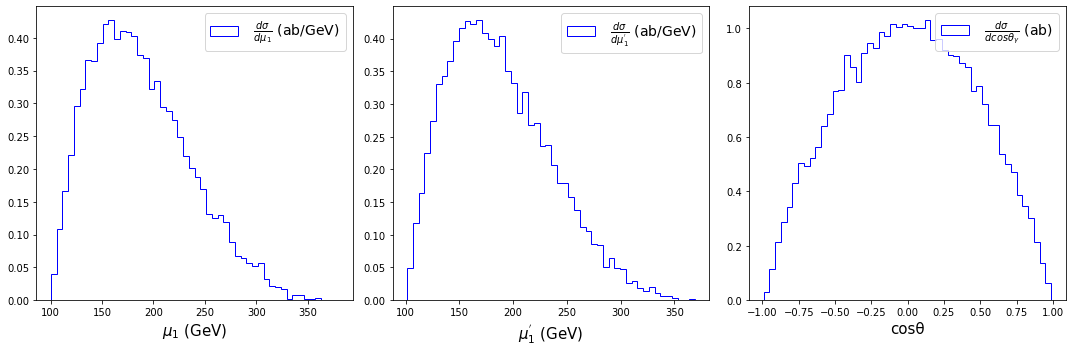

In [5]:
## Plots from PM
ProductionPlot = PM.Plotter('dσ_dμdμpdcosθ', [2,1], (15,5), 50)
ProductionPlot.addPlot([dσ_dμdμp_sqrtS_500_dict, dσ_dcosθ_dict], [['blue','blue'],['blue']], 'linear')
ProductionPlot.addFeatures([dσ_dμdμp_sqrtS_500_dict, dσ_dcosθ_dict], 
                           [r'$μ_{1}$ (GeV)',r"$μ_{1}^{'}$ (GeV)",r'cosθ'],
                      legend=True, legendlabel=[[r'$\,\,\frac{dσ}{dμ_{1}}$ (ab/GeV)'],
                                              [r"$\,\,\frac{dσ}{dμ_{1}^{'}}$ (ab/GeV)"],
                                              [r"$\,\,\frac{dσ}{dcosθ_{γ}}$ (ab)"]])
plt.tight_layout()

# Cross Section σISR (with Initial State Radiation) 

In [6]:
## Training & Unweighting for Production Cross Section ISR 
dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict = VMC.run_MC_dσ_deγdcosθγdμdμp(NPoints=100000, 
                                                                 sqrtS=500, μ0=100, μϼ=μϼ100R80_k1010)

Running dσ/deγdcosθγdμdμp MC for √s = 500 ... 
(97539,) (97539,) (97539,) (97539,)
0 of 12100
5000 of 12100
10000 of 12100
(97539,)
(13431,)
Returning μ1, μ1p Events, eγ Events, cosθγ Events, Integral


In [7]:
# Number of Events & Integral 
print("# of (μ,μ',Eγ,cosθγ) events: " + str(np.shape(dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict["μ1 Events"])))
# Cross Section 
print('σISR = ' + str(dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict['Integral']) + ' ab ')

# of (μ,μ',Eγ,cosθγ) events: (13431,)
σISR = 431.38072213956565 ab 


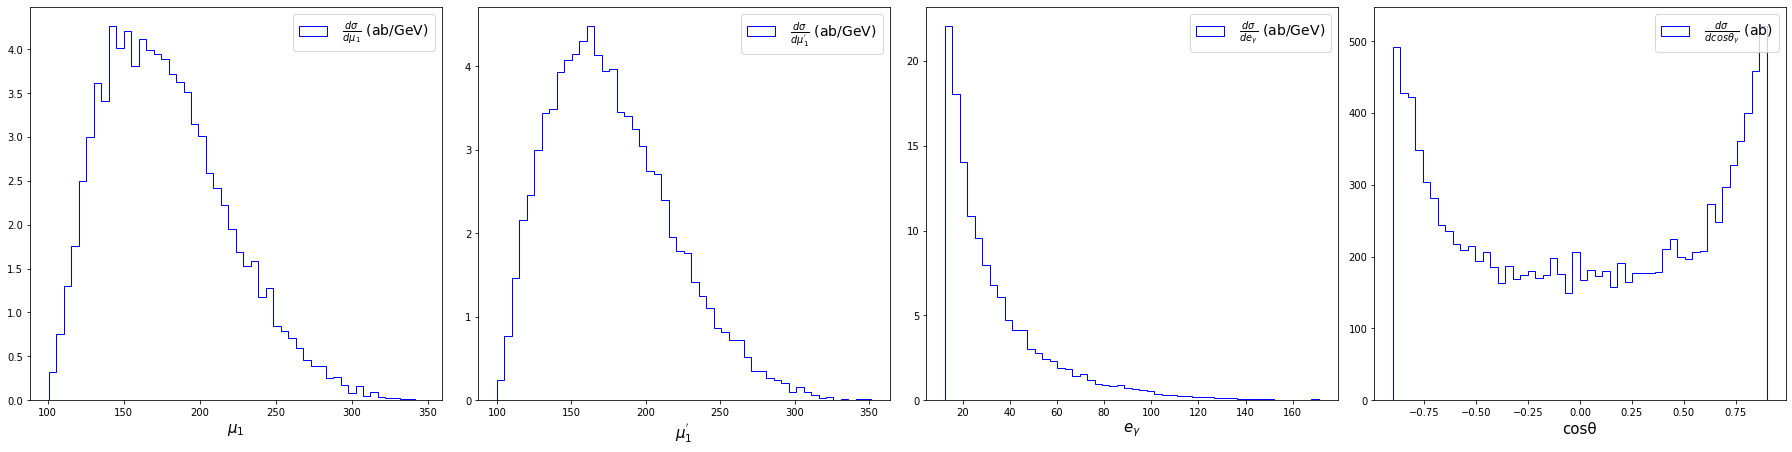

In [8]:
## Plotting with class
ProductionPlot = PM.Plotter('dσ_deγdcosθγdμ1dμ1p', [4], (25,6), 50)
ProductionPlot.addPlot([dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict], [['blue','blue','blue','blue']], 'linear')
ProductionPlot.addFeatures([dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict], [r'$μ_{1}$',r"$μ_{1}^{'}$",r'$e_{γ}$',r'cosθ'],
                      legend=True, legendlabel=[[r'$\,\,\frac{dσ}{dμ_{1}}$ (ab/GeV)'],
                                        [r"$\,\,\frac{dσ}{dμ_{1}^{'}}$ (ab/GeV)"],
                                        [r'$\,\,\frac{dσ}{de_{γ}}$ (ab/GeV)'],
                                        [r"$\,\,\frac{dσ}{dcosθ_{γ}}$ (ab)"]])

# Rate Γ

### 3-body Decay MC

In [9]:
## Mass Spectrum of Benchmark Model: 
## μ0 = 100 GeV | sin^2(α) = 0.1 | R^{-1} = 30 GeV | k = 10^10 GeV  
## Calculated from Mathematica: 
MassSpec = np.array([102.442,104.436,106.861,110.122,114.169,118.899,124.205,129.994,136.182,142.706,
                         149.52,156.593,163.899,171.411,179.103,186.95,194.932,203.039,211.261,219.591,
                         228.018,236.534,245.128,253.793,262.525,271.319,280.171,289.076,298.029,307.026,
                         316.062,325.135,334.242,343.381,352.551,361.748,370.971,380.217,389.483,398.77])
# Check that dm^2 ~ 2mdm
print(VMC.Δm(200, MassSpec)*2*200)
print(VMC.Δm2(200, MassSpec))

3242.7999999999997
3226.3508969999966


In [10]:
 ## Running MC for dΓ3/dμ2dx3dx4 for different μ1 ## 
NPoints = 50000  ## 100,000 takes ~1 hour
masses = [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
          195, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 
          340, 350, 360, 370, 380, 390]
d3Γ3_ds = []
for i, m in enumerate(masses):
    d3Γ3_ds.append(m)
    d3Γ3_ds.append(VMC.run_MC_dΓ3_dμ2(NPoints, m, 100, μϼ100R80_k1010, VMC.Δm2(m, MassSpec)))

Running dΓ3/dμ2 MC for μ1 = 101 ... 
1.4590275166987983e-22
(49780,) (49780,) (49780,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral
Running dΓ3/dμ2 MC for μ1 = 102 ... 
1.661415839452121e-20
(49755,) (49755,) (49755,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral
Running dΓ3/dμ2 MC for μ1 = 103 ... 
2.8465387682808683e-19
(49738,) (49738,) (49738,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral
Running dΓ3/dμ2 MC for μ1 = 104 ... 
1.9753274031883984e-18
(49726,) (49726,) (49726,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral
Running dΓ3/dμ2 MC for μ1 = 105 ... 
9.91667396080552e-18
(49713,) (49713,) (49713,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral
Running dΓ3/dμ2 MC for μ1 = 106 ... 
5.277382961219955e-17
(49709,) (49709,) (49709,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral
Running dΓ3/dμ2 MC for μ1 = 107 

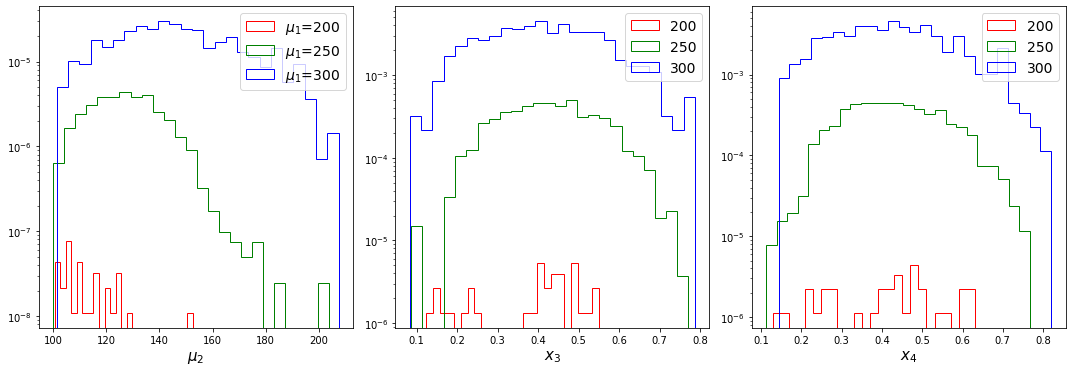

In [11]:
## Plotting with class
def IndOfM(m):  return d3Γ3_ds.index(m)+1
ThreeBodyDecayPlot = PM.Plotter('d3Γ3_dμ2dx3dx4', [3], (15,5), 25)
# ThreeBodyDecayPlot.addPlot([d3Γ3_dμ2dx3dx4_μ1_150_dict], 'blue', 'linear')
ThreeBodyDecayPlot.addPlot([d3Γ3_ds[IndOfM(200)]], [['red','red','red']], 'log')
ThreeBodyDecayPlot.addPlot([d3Γ3_ds[IndOfM(250)]], [['green','green','green']], 'log')
ThreeBodyDecayPlot.addPlot([d3Γ3_ds[IndOfM(300)]], [['blue','blue','blue']], 'log')

ThreeBodyDecayPlot.addFeatures([d3Γ3_ds[IndOfM(200)]], [r'$μ_{2}$',r"$x_{3}$",r'$x_{4}$'],
                      legend=True, legendlabel=[[r'$μ_{1}$=200',r'$μ_{1}$=250',r'$μ_{1}$=300'],
                                                ['200','250','300'], ['200','250','300']] )

# Finding Threshold

In [22]:
# Compute some extra masses near the gap 
# masses = [103.5, 104.5, 105.25, 105.5, 106, 107, 108, 109, 110, 115]
masses = [106.5, 107.5]
for i, m in enumerate(masses):
    d3Γ3_ds.append(m)
    d3Γ3_ds.append(VMC.run_MC_dΓ3_dμ2(NPoints, m, 100, μϼ100R80_k1010, Δm2(m, MassSpec)))

Running dΓ3/dμ2 MC for μ1 = 106.5 ... 
9.488203342139914e-17
(49707,) (49707,) (49707,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral
Running dΓ3/dμ2 MC for μ1 = 107.5 ... 
2.715092593006307e-16
(49697,) (49697,) (49697,)
0 of 6156
5000 of 6156
Returning μ2 Events, x3 Events, x4 Events, Integral


In [23]:
###############
# Decay Rates #
###############
masses = [101,102,103,104,105,106,106.5,107,107.5,108,109,110,
          120, 180, 200, 210, 220, 230, 240, 370, 390]

Γ3 = []
for i in range(len(masses)):
    Γ3.append(d3Γ3_ds[IndOfM(masses[i])]['Integral'])
Γ3_dict = dict(zip(masses,Γ3))

print('Decay Rates')
for key, value in Γ3_dict.items():
    mass_key = key
    Γ3_value = value
    print("{:<10} {:<10}".format(mass_key, Γ3_value))

#################
# Decay Lengths #
#################
print('')
c = 3 * 10**8                    ## m/s
hbar = 6.58*10**(-16)*10**(-9)   ## GeV*s
L = c*hbar/np.array(Γ3)
L_dict = dict(zip(masses,L))

print('Decay Lengths')
for key, value in L_dict.items():
    mass_key = key
    L_value = value
    print("{:<10} {:<10}".format(mass_key, L_value))

Decay Rates
101        1.4590275166987983e-22
102        1.661415839452121e-20
103        2.8465387682808683e-19
104        1.9753274031883984e-18
105        9.91667396080552e-18
106        5.277382961219955e-17
106.5      9.488203342139914e-17
107        1.491924952886864e-16
107.5      2.715092593006307e-16
108        4.2851206075813577e-16
109        1.4002173296941127e-15
110        3.0003749717567283e-15
120        9.41109160049853e-13
180        7.231033928964852e-08
200        6.954097708316556e-07
210        3.0060035665760723e-06
220        1.07449912766025e-05
230        3.0692096308673564e-05
240        6.890126367304552e-05
370        0.010616081136065623
390        0.015515539856290811

Decay Lengths
101        1352955.9774625641
102        11881.432409185161
103        693.4737801558814
104        99.93280085183571
105        19.905867711311288
106        3.7404903424777745
106.5      2.0804781778156913
107        1.3231228529158416
107.5      0.7270470278195093
108      

# Defining Γ3 Interpolation Function  ( used in sampling ) 

/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_59397/1074095108.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,10**(-10))


(1.4545488528862845e-23, 1e-10)

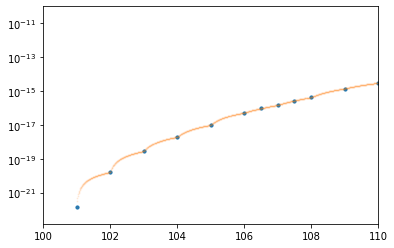

In [24]:
## 3-body Rate Interpolation 
RateArray = []
masspoints = [101,102,103,104,105,106,106.5,107,107.5,108,109,110,120,130,140,150,160,170,180,190,
              195,200,210,220,230,240,250,260,270,280,290,
              300,310,320,330,340,350,360,370,380,390]
for m in masspoints:
#     RateArray.append(eval('d3Γ3_dμ2dx3dx4_μ1_' + str(m) + '_dict')['Integral'])
    RateArray.append(d3Γ3_ds[IndOfM(m)]['Integral'])
Γ3_interp = sp.interpolate.interp1d(masspoints, RateArray, kind='linear')
plt.scatter(masspoints, RateArray, s=10)
ms = np.arange(101,390,1/100)
plt.scatter(ms, Γ3_interp(ms), s=1, alpha=0.1)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(100,110)
plt.ylim(0,10**(-10))

# Sampling, Rescaling, & Kinematics

In [28]:
#######################################################
##################  Production & Decay   ##############
##################     conversion to     ##############
##################       4-vectors       ##############
##################   ( in LHE format )   ##############
#######################################################
MC_Events_LHE = []

def sample(μ1, μ1_actual, prime, n, temp_event, threshold):
    μ2x3x4_Γ3_hist = d3Γ3_ds[IndOfM(μ1)]['All Events']
    FinalState3body_FVs(μ1, μ1_actual, prime, n, temp_event, threshold, Γ3_interp, μ2x3x4_Γ3_hist)

###############################
## When to stop the cascade ## 
threshold = 106
##############################
μ1_histo  = dσ_dμdμp_sqrtS_500_dict['μ1 Events']
μ1p_histo = dσ_dμdμp_sqrtS_500_dict['μ1p Events']
cosθ_histo = dσ_dcosθ_dict['cosθ Events']


for i in range(len(μ1_histo)):
    temp_event = []
#------------------------------------------------------------------------------------#
#                                       Production                                   #
#------------------------------------------------------------------------------------#
######################################### μ1 #########################################
    μ1_sample   = μ1_histo[i]
    μ1p_sample  = μ1p_histo[i]
    cosθ_sample = np.arccos(np.random.choice(cosθ_histo))
#     cosθ_sample = np.arccos(cosθ_histo[i])
    ProductionFVs(μ1_sample, μ1p_sample, cosθ_sample, temp_event, False, threshold, Γ3_int=Γ3_interp, s=500**2)

#------------------------------------------------------------------------------------#
#                                         Decay                                      #
#------------------------------------------------------------------------------------#
#################################### μ2, f2a, f2b ####################################
    n = 0
    while True:
        n = n + 1
        ## get the mass 
        if n == 1:                 ### mass of 1st step 
            mass = μ1_sample  
        if n != 1:                 ### mass of nth step
#             print(n)
            particle_number = 1 + (3*n - 6)  ## for n=2, PID2 is after PID1. for n>2, PIDn is 4 after PID(n-1).
#             print('particle number: ' + str(particle_number))
#             print(temp_event)
            mass = float(np.array(temp_event)[particle_number,2])
        if mass < threshold: 
            break
        else:  
            if    101  < mass < 102:   sample(101, mass, False, n, temp_event, threshold)
            elif  102  < mass < 103:   sample(102, mass, False, n, temp_event, threshold)
            elif  103  < mass < 104:   sample(103, mass, False, n, temp_event, threshold)
            elif  104  < mass < 105:   sample(104, mass, False, n, temp_event, threshold)
            elif  105  < mass < 106:   sample(105, mass, False, n, temp_event, threshold)
            elif  106  < mass < 106.5: sample(106, mass, False, n, temp_event, threshold)
            elif  106.5  < mass < 107: sample(106.5, mass, False, n, temp_event, threshold)
            elif  107  < mass < 107.5: sample(107, mass, False, n, temp_event, threshold)
            elif  107.5  < mass < 108: sample(107.5, mass, False, n, temp_event, threshold)
            elif  108  < mass < 109:   sample(108, mass, False, n, temp_event, threshold)
            elif  109  < mass < 110:   sample(109, mass, False, n, temp_event, threshold)
            elif  110  < mass < 120:   sample(110, mass, False, n, temp_event, threshold)
            elif  120  < mass < 130:   sample(120, mass, False, n, temp_event, threshold)
            elif  130  < mass < 140:   sample(130, mass, False, n, temp_event, threshold)
            elif  140  < mass < 150:   sample(140, mass, False, n, temp_event, threshold)
            elif  150  < mass < 160:   sample(150, mass, False, n, temp_event, threshold)
            elif  160  < mass < 170:   sample(160, mass, False, n, temp_event, threshold)
            elif  170  < mass < 180:   sample(170, mass, False, n, temp_event, threshold)
            elif  180  < mass < 190:   sample(180, mass, False, n, temp_event, threshold)
            elif  190  < mass < 195:   sample(190, mass, False, n, temp_event, threshold)
            elif  195  < mass < 200:   sample(195, mass, False, n, temp_event, threshold)
            elif  200  < mass < 210:   sample(200, mass, False, n, temp_event, threshold)
            elif  210  < mass < 220:   sample(210, mass, False, n, temp_event, threshold)
            elif  220  < mass < 230:   sample(220, mass, False, n, temp_event, threshold)
            elif  230  < mass < 240:   sample(230, mass, False, n, temp_event, threshold)
            elif  240  < mass < 250:   sample(240, mass, False, n, temp_event, threshold)
            elif  250  < mass < 260:   sample(250, mass, False, n, temp_event, threshold)
            elif  260  < mass < 270:   sample(260, mass, False, n, temp_event, threshold)
            elif  270  < mass < 280:   sample(270, mass, False, n, temp_event, threshold)
            elif  280  < mass < 290:   sample(280, mass, False, n, temp_event, threshold)
            elif  290  < mass < 300:   sample(290, mass, False, n, temp_event, threshold)
            elif  300  < mass < 310:   sample(300, mass, False, n, temp_event, threshold)
            elif  310  < mass < 320:   sample(310, mass, False, n, temp_event, threshold)
            elif  320  < mass < 330:   sample(320, mass, False, n, temp_event, threshold)
            elif  330  < mass < 340:   sample(330, mass, False, n, temp_event, threshold)
            elif  340  < mass < 350:   sample(340, mass, False, n, temp_event, threshold)
            elif  350  < mass < 360:   sample(350, mass, False, n, temp_event, threshold)
            elif  360  < mass < 370:   sample(360, mass, False, n, temp_event, threshold)
            elif  370  < mass < 380:   sample(370, mass, False, n, temp_event, threshold)
            elif  380  < mass < 390:   sample(380, mass, False, n, temp_event, threshold)
            elif  390  < mass < 400:   sample(390, mass, False, n, temp_event, threshold)
#             elif  390  < mass:   sample(390, mass, 3, False, n, temp_event, threshold)

#------------------------------------------------------------------------------------#
#                                       Production                                   #
#------------------------------------------------------------------------------------#
######################################### μ1p ########################################
    μ1_sample  = μ1_histo[i]
    μ1p_sample = μ1p_histo[i]
    cosθ_sample = np.arccos(np.random.choice(cosθ_histo)) 
#     cosθ_sample = np.arccos(cosθ_histo[i])
    ProductionFVs(μ1_sample, μ1p_sample, cosθ_sample, temp_event, True, threshold, Γ3_int=Γ3_interp, s=500**2)
    
#------------------------------------------------------------------------------------#
#                                         Decay                                      #
#------------------------------------------------------------------------------------#
################################### μ2p, f2ap, f2bp ##################################
    n = 0
    while True:
        n = n + 1
        ## get the mass
        length = len(temp_event)
        if n == 1:              ### mass of 1st step
            mass = μ1p_sample 
        if n != 1:              ### mass of nth step
            particle_number = length - 3
            mass = float(np.array(temp_event)[particle_number,2])
        if mass < threshold:
            break
        else:  
            if    101  < mass < 102:   sample(101, mass, True, n, temp_event, threshold)
            elif  102  < mass < 103:   sample(102, mass, True, n, temp_event, threshold)
            elif  103  < mass < 104:   sample(103, mass, True, n, temp_event, threshold)
            elif  104  < mass < 105:   sample(104, mass, True, n, temp_event, threshold)
            elif  105  < mass < 106:   sample(105, mass, True, n, temp_event, threshold)
            elif  106  < mass < 106.5: sample(106, mass, True, n, temp_event, threshold)
            elif  106.5  < mass < 107: sample(106.5, mass, True, n, temp_event, threshold)
            elif  107  < mass < 107.5: sample(107, mass, True, n, temp_event, threshold)
            elif  107.5  < mass < 108: sample(107.5, mass, True, n, temp_event, threshold) 
            elif  108  < mass < 109:   sample(108, mass, True, n, temp_event, threshold) 
            elif  109  < mass < 110:   sample(109, mass, True, n, temp_event, threshold) 
            elif  110  < mass < 120:   sample(110, mass, True, n, temp_event, threshold)
            elif  120  < mass < 130:   sample(120, mass, True, n, temp_event, threshold)
            elif  130  < mass < 140:   sample(130, mass, True, n, temp_event, threshold)
            elif  140  < mass < 150:   sample(140, mass, True, n, temp_event, threshold)
            elif  150  < mass < 160:   sample(150, mass, True, n, temp_event, threshold)
            elif  160  < mass < 170:   sample(160, mass, True, n, temp_event, threshold)
            elif  170  < mass < 180:   sample(170, mass, True, n, temp_event, threshold)
            elif  180  < mass < 190:   sample(180, mass, True, n, temp_event, threshold)
            elif  190  < mass < 195:   sample(190, mass, True, n, temp_event, threshold)
            elif  195  < mass < 200:   sample(195, mass, True, n, temp_event, threshold)
            elif  200  < mass < 210:   sample(200, mass, True, n, temp_event, threshold)
            elif  210  < mass < 220:   sample(210, mass, True, n, temp_event, threshold)
            elif  220  < mass < 230:   sample(220, mass, True, n, temp_event, threshold)
            elif  230  < mass < 240:   sample(230, mass, True, n, temp_event, threshold)
            elif  240  < mass < 250:   sample(240, mass, True, n, temp_event, threshold)
            elif  250  < mass < 260:   sample(250, mass, True, n, temp_event, threshold)
            elif  260  < mass < 270:   sample(260, mass, True, n, temp_event, threshold)
            elif  270  < mass < 280:   sample(270, mass, True, n, temp_event, threshold)
            elif  280  < mass < 290:   sample(280, mass, True, n, temp_event, threshold)
            elif  290  < mass < 300:   sample(290, mass, True, n, temp_event, threshold)
            elif  300  < mass < 310:   sample(300, mass, True, n, temp_event, threshold)
            elif  310  < mass < 320:   sample(310, mass, True, n, temp_event, threshold)
            elif  320  < mass < 330:   sample(320, mass, True, n, temp_event, threshold)
            elif  330  < mass < 340:   sample(330, mass, True, n, temp_event, threshold)
            elif  340  < mass < 350:   sample(340, mass, True, n, temp_event, threshold)
            elif  350  < mass < 360:   sample(350, mass, True, n, temp_event, threshold)
            elif  360  < mass < 370:   sample(360, mass, True, n, temp_event, threshold)
            elif  370  < mass < 380:   sample(370, mass, True, n, temp_event, threshold)
            elif  380  < mass < 390:   sample(380, mass, True, n, temp_event, threshold)
            elif  390  < mass < 400:   sample(390, mass, True, n, temp_event, threshold)
#             elif  390  < mass:   sample(390, mass, True, n, temp_event, threshold)
    ############ Append ###########
    MC_Events_LHE.append(temp_event)
    ###############################
print('done')
print(np.shape(MC_Events_LHE))

done
(10917,)


In [29]:
## Make MyLHE file ## (not an actual LHE file, but used in VegasMC_WIC_Analysis)
ConvertToLHE.arr_to_MyLHE('MC_Events', MC_Events_LHE, dσ_dμdμp_sqrtS_500_dict)

In [30]:
## Make LHE file ##
ConvertToLHE.arr_to_LHE_temp('MC_Events', MC_Events_LHE, dσ_dμdμp_sqrtS_500_dict)